# SVM 모델 (raw data)

In [13]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## 분석할 파일 불러오기(각각의 voc파일에 대해서 raw_data_to_dataframe.ipynb를 수행했다고 가정)

In [2]:
voc2_path = "/home/gracejang42/CP/final_data/voc2/long_df.csv"
voc3_path = "/home/gracejang42/CP/final_data/voc3/long_df.csv"
voc4_path = "/home/gracejang42/CP/final_data/voc4/long_df.csv"
voc5_path = "/home/gracejang42/CP/final_data/voc5/long_df.csv"
voc7_path = "/home/gracejang42/CP/final_data/voc7/long_df.csv"
voc8_path = "/home/gracejang42/CP/final_data/voc8/long_df.csv"
voc9_path = "/home/gracejang42/CP/final_data/voc9/long_df.csv"
voc10_path = "/home/gracejang42/CP/final_data/voc10/long_df.csv"

## 머신러닝을 위한 feature table 만들기 (raw data)

In [3]:
voc2 = pd.read_csv(voc2_path)
voc3 = pd.read_csv(voc3_path)
voc4 = pd.read_csv(voc4_path)
voc5 = pd.read_csv(voc5_path)
voc7 = pd.read_csv(voc7_path)
voc8 = pd.read_csv(voc8_path)
voc9 = pd.read_csv(voc9_path)
voc10 = pd.read_csv(voc10_path)

# 라벨 부여
voc2["label"] = 0
voc3["label"] = 1
voc4["label"] = 2
voc5["label"] = 3
voc7["label"] = 4
voc8["label"] = 5
voc9["label"] = 6
voc10["label"] = 7

# sample_key 생성
for name, df_ in zip(["voc2", "voc3", "voc4", "voc5", "voc7", "voc8", "voc9", "voc10"], [voc2, voc3, voc4, voc5, voc7, voc8, voc9, voc10]):
    df_["sample_key"] = name + "_" + df_["sample_id"].astype(str)

df = pd.concat([voc2, voc3, voc4, voc5, voc7, voc8, voc9, voc10], ignore_index=True)

# feature 생성 (sensor_t시간)
df["feature"] = df["sensor"] + "_t" + df["time_index"].astype(str)

# wide format (행=sample, 열=feature)
wide = df.pivot_table(
    index="sample_key",
    columns="feature",
    values="intensity"
).fillna(0.0)

# X = feature matrix, y = labels
X = wide.values.astype(np.float32)
y = df.groupby("sample_key")["label"].first().values.astype(np.int64)

print("\n Data Ready")
print("X:", X.shape)
print("y:", y.shape)
print("Class distribution:", np.bincount(y))



 Data Ready
X: (80, 7200)
y: (80,)
Class distribution: [10 10 10 10 10 10 10 10]


In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

df = pd.concat([voc2, voc3, voc4, voc5, voc7, voc8, voc9, voc10], ignore_index=True)
df

,sample_id,time_index,sensor,intensity,label,sample_key
0,1,0,pos1_Sensor2,542.419136,0,voc2_1
1,1,0,pos1_Sensor1,163.974254,0,voc2_1
2,1,0,pos1_Sensor11,823.123927,0,voc2_1
3,1,0,pos1_Sensor12,615.730435,0,voc2_1
4,1,0,pos2_Sensor4,472.492491,0,voc2_1
...,...,...,...,...,...,...
575995,10,199,pos8_Sensor34,151.336330,7,voc10_10
575996,10,199,pos9_Sensor30,270.724714,7,voc10_10
575997,10,199,pos9_Sensor29,567.987076,7,voc10_10
575998,10,199,pos9_Sensor31,1014.048324,7,voc10_10


In [5]:
df["feature"] = df["sensor"] + "_t" + df["time_index"].astype(str)

wide = df.pivot_table(
    index="sample_key",
    columns="feature",
    values="intensity"
)

In [6]:
# 각 sample_key별 ground truth label
labels = df.groupby("sample_key")["label"].first()

In [7]:
# 결측값 0으로 처리
wide = wide.fillna(0.0)

In [8]:
X = wide.values.astype(np.float32)
y = labels.values.astype(np.int64)

print("\n Final Training Matrix Shape:", X.shape)
print(" Label Count:", np.bincount(y))
print("클래스 매핑: 0=VOC2, 1=VOC3, 2=VOC4, 3=VOC5, 4=VOC7, 5=VOC8, 6=VOC9, 7=VOC10")


 Final Training Matrix Shape: (80, 7200)
 Label Count: [10 10 10 10 10 10 10 10]
클래스 매핑: 0=VOC2, 1=VOC3, 2=VOC4, 3=VOC5, 4=VOC7, 5=VOC8, 6=VOC9, 7=VOC10


## SVM model

In [9]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=10.0, gamma="scale", random_state=SEED))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

print("\n 10-fold Cross Validation Running...")


 10-fold Cross Validation Running...


In [10]:
cv_scores = cross_val_score(
    pipeline,
    X, y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

print("\n Fold accuracy:", cv_scores)
print(f" Mean accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


 Fold accuracy: [1.    1.    1.    1.    0.875 1.    1.    1.    0.875 0.875]
 Mean accuracy = 0.9625 ± 0.0573



===== Cross-validated Classification Report =====
              precision    recall  f1-score   support

        VOC2       0.91      1.00      0.95        10
        VOC3       1.00      0.90      0.95        10
        VOC4       1.00      1.00      1.00        10
        VOC5       1.00      1.00      1.00        10
        VOC7       1.00      1.00      1.00        10
        VOC8       0.91      1.00      0.95        10
        VOC9       0.90      0.90      0.90        10
       VOC10       1.00      0.90      0.95        10

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



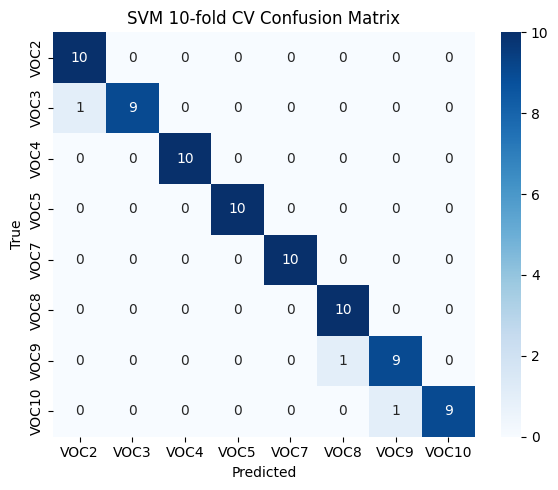

In [11]:
# =========================
# 7. Cross-validated predictions → confusion matrix
# =========================
y_pred_cv = cross_val_predict(
    pipeline,
    X, y,
    cv=cv,
    n_jobs=-1
)

target_names = ["VOC2", "VOC3", "VOC4","VOC5","VOC7","VOC8","VOC9","VOC10"]

print("\n===== Cross-validated Classification Report =====")
print(classification_report(
    y, y_pred_cv,
    target_names=target_names
))

cm = confusion_matrix(y, y_pred_cv)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM 10-fold CV Confusion Matrix")
plt.tight_layout()
plt.show()

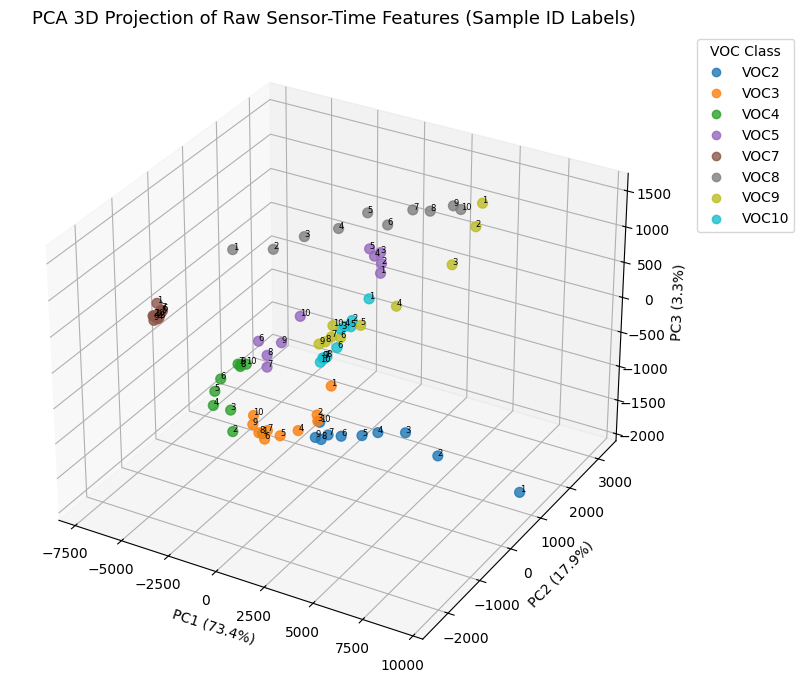

In [14]:
# =========================
# 8. PCA 3D + sample_id 숫자 라벨 표시
# =========================
pca_3d = PCA(n_components=3, random_state=SEED)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=y,
    cmap="tab10",
    s=50,
    alpha=0.8
)

# VOC 클래스 legend
handles, _ = scatter.legend_elements(prop="colors")
ax.legend(handles, target_names, title="VOC Class",
          bbox_to_anchor=(1.05, 1), loc="upper left")

# 🔹 sample_key에서 sample_id만 떼어와서 숫자 라벨로 사용
short_labels = [key.split("_")[1] for key in wide.index]  # "voc3_5" → "5"

for i, label in enumerate(short_labels):
    ax.text(
        X_pca_3d[i, 0],
        X_pca_3d[i, 1],
        X_pca_3d[i, 2],
        str(label),
        fontsize=6,
        color="black"
    )

ax.set_title("PCA 3D Projection of Raw Sensor-Time Features (Sample ID Labels)",
             fontsize=13)
ax.set_xlabel(f"PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)")

plt.tight_layout()
plt.show()

## random forest

In [15]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (80, 7200)
y shape: (80,)


In [16]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=SEED,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

print("\n🌲 Random Forest 10-fold CV 시작...")


🌲 Random Forest 10-fold CV 시작...


In [17]:
rf_scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print("각 fold accuracy:", rf_scores)
print(f"📊 평균 accuracy = {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

각 fold accuracy: [0.75  0.875 0.75  1.    0.875 0.875 0.75  0.875 0.875 0.75 ]
📊 평균 accuracy = 0.8375 ± 0.0800


In [18]:
y_pred_rf = cross_val_predict(rf_pipeline, X, y, cv=cv, n_jobs=-1)

print("\n===== Random Forest Cross-validated Classification Report =====")
print(classification_report(y, y_pred_rf, target_names=["VOC1", "VOC2", "VOC3", "VOC4", "VOC5", "VOC8", "VOC9", "VOC10"]))


===== Random Forest Cross-validated Classification Report =====
              precision    recall  f1-score   support

        VOC1       0.75      0.90      0.82        10
        VOC2       0.88      0.70      0.78        10
        VOC3       1.00      1.00      1.00        10
        VOC4       1.00      1.00      1.00        10
        VOC5       0.91      1.00      0.95        10
        VOC8       0.82      0.90      0.86        10
        VOC9       0.67      0.40      0.50        10
       VOC10       0.67      0.80      0.73        10

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.83        80
weighted avg       0.84      0.84      0.83        80



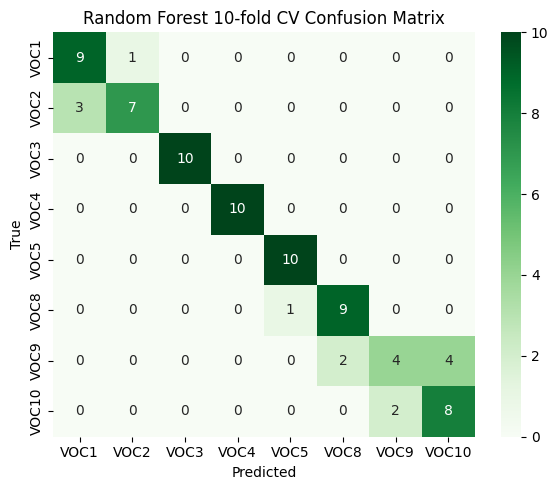

In [19]:
cm = confusion_matrix(y, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["VOC1", "VOC2", "VOC3", "VOC4", "VOC5", "VOC8", "VOC9", "VOC10"],
            yticklabels=["VOC1", "VOC2", "VOC3", "VOC4", "VOC5", "VOC8", "VOC9", "VOC10"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest 10-fold CV Confusion Matrix")
plt.tight_layout()
plt.show()